# Sparkify Churn Analysis

In this notebook, we build a model for Sparkify, an imaginary music streaming application. We have access to the log files, and engineer features in order to be able to predict churn. 

We first load the necessary libraries.

In [35]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, substring, col, when, desc, min, max, sum, \
split, udf, count, countDistinct, rand, struct, isnan, isnull, from_unixtime, dayofmonth, month
from pyspark.sql.types import IntegerType, ArrayType, FloatType, DoubleType, Row, DateType
from pyspark.ml.linalg import DenseVector, SparseVector

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Load and Clean Dataset

First load and then clean the dataset, checking for invalid or missing data. 

In [2]:
spark = SparkSession \
    .builder \
    .appName("Wrangling Data") \
    .getOrCreate()

path = "mini_sparkify_event_data.json"
df = spark.read.json(path)
df.persist()

df.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000| 

In [3]:
# We also create a view, in order to leverage the SQL syntax where applicable
df.createOrReplaceTempView('logs')

In [4]:
# Visualize the presence of potential null values in critical columns
df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [5]:
# Explore missing values in firstName column
df.where(col('firstName').isNull()).show(10)

+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|artist|      auth|firstName|gender|itemInSession|lastName|length|level|location|method| page|registration|sessionId|song|status|           ts|userAgent|userId|
+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|  null|Logged Out|     null|  null|          100|    null|  null| free|    null|   GET| Home|        null|        8|null|   200|1538355745000|     null|      |
|  null|Logged Out|     null|  null|          101|    null|  null| free|    null|   GET| Help|        null|        8|null|   200|1538355807000|     null|      |
|  null|Logged Out|     null|  null|          102|    null|  null| free|    null|   GET| Home|        null|        8|null|   200|1538355841000|     null|      |
|  null|Logged Out|     null|  nul

In [6]:
# Explore missing values in the artist column
df.where(col('artist').isNull()).show(10)

+------+----------+---------+------+-------------+--------+------+-----+--------------------+------+---------------+-------------+---------+----+------+-------------+--------------------+------+
|artist|      auth|firstName|gender|itemInSession|lastName|length|level|            location|method|           page| registration|sessionId|song|status|           ts|           userAgent|userId|
+------+----------+---------+------+-------------+--------+------+-----+--------------------+------+---------------+-------------+---------+----+------+-------------+--------------------+------+
|  null| Logged In|    Colin|     M|           54| Freeman|  null| paid|     Bakersfield, CA|   PUT|Add to Playlist|1538173362000|       29|null|   200|1538352905000|Mozilla/5.0 (Wind...|    30|
|  null| Logged In|    Micah|     M|           84|    Long|  null| free|Boston-Cambridge-...|   GET|    Roll Advert|1538331630000|        8|null|   200|1538353150000|"Mozilla/5.0 (Win...|     9|
|  null| Logged In|    Mi

In [7]:
# Filter out logged out users
df = df.where(col('auth') != 'Logged Out')

Although at a top level there are no missing values in the userId or sessionId columns, looking further at missing values in the firstName columns shows that logged out users have empty (but not null) user ID's. We exclude these users for our analysis. There are also missing values in the artist column, but these correspond to logs for non-music related actions ("Add to Playlist", "Roll Advert") etc... As long as these users are logged in, we want to keep this activity for they could be important markers of activity for classification.

# Exploratory Data Analysis

## Define Churn

In [8]:
# We start by visualizing the variables available
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [9]:
# We visualize the first few rows
df.show(n=5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000| 

In [10]:
# We visualize all the events and their associated counts
df.groupBy('Page').count().show()

+--------------------+------+
|                Page| count|
+--------------------+------+
|              Cancel|    52|
|    Submit Downgrade|    63|
|         Thumbs Down|  2546|
|                Home| 10118|
|           Downgrade|  2055|
|         Roll Advert|  3933|
|              Logout|  3226|
|       Save Settings|   310|
|Cancellation Conf...|    52|
|               About|   509|
| Submit Registration|     5|
|            Settings|  1514|
|            Register|    18|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|            NextSong|228108|
|           Thumbs Up| 12551|
|                Help|  1477|
|             Upgrade|   499|
|               Error|   253|
+--------------------+------+
only showing top 20 rows



In [11]:
# We see how many unique users are present in this dataset
spark.sql('SELECT COUNT(DISTINCT userId) AS nb_users FROM logs').show()

+--------+
|nb_users|
+--------+
|     226|
+--------+



In [12]:
# Create a dataset with all user ID's and a label which specifies whether that individual churned or not

# First a dataset with users who churned
churn = spark.sql('SELECT DISTINCT userId, 1 as churn FROM logs WHERE Page = "Cancellation Confirmation"')

# Then the other users
no_churn = spark.sql('SELECT DISTINCT userId, 0 as churn FROM logs \
                      WHERE userId NOT IN (SELECT DISTINCT userId FROM logs WHERE Page = "Cancellation Confirmation")')

# Create a dataframe from the union of the two, shuffling the rows
churn_df = churn.union(no_churn)
churn_df.createOrReplaceTempView('churn')
churn_df = spark.sql('SELECT * FROM churn ORDER BY RAND()')
churn_df.createOrReplaceTempView('churn')

# Check that we have the right number of users
churn_df.count()

226

In [13]:
# visualize the distribution of users between churning or not
churn_pd_df = churn_df.toPandas()
churn_pd_df.groupby('churn', as_index=False).count()

,churn,userId
0,0,174
1,1,52


We define churn at the user ID level by finding cancellation confirmation events and then creating an indicator that a user, at any time in its history, will churn. This approach allows us to study behavior prior to churning to try and build a predictive model and extract behaviors that indicate a risk of churning in the future.

It is important to note that our dataset has a class imbalance, containing more than 3 times as many users who did not churn. We will need to keep this in mind when building our model and use some up- or downsampling techniques. 

## Feature Engineering

Now that we have defined churn, we can engineer features by studying differences between the group of users who churned and those who did not.

In [14]:
# Join our churn dataset to our full dataset to add a column
joined_df = df.join(churn_df, on='userId')

# Use this column to create some aggregates, first comparing the level of the account
joined_df.groupBy(['churn', 'level']).count().show(5)

+-----+-----+------+
|churn|level| count|
+-----+-----+------+
|    0| free| 43430|
|    0| paid|189957|
|    1| paid| 32476|
|    1| free| 12388|
+-----+-----+------+



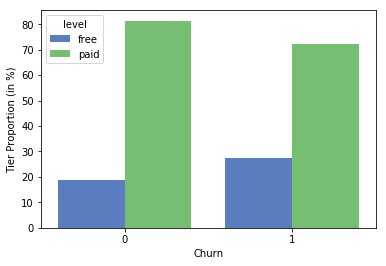

In [15]:
# Build a data visualization: a grouped bar chart of proportions
level_df = joined_df.groupBy(['churn', 'level']).count().toPandas()
churn_sum = level_df.groupby('churn', as_index=False).sum()
level_df['proportion'] = (level_df.join(churn_sum, on = 'churn', lsuffix='_1')['count_1']/level_df.join(churn_sum, on = 'churn', lsuffix='_1')['count'])*100

g = sns.barplot(x="churn", y="proportion", hue="level", data=level_df,
                palette="muted")
g.set(xlabel='Churn', ylabel="Tier Proportion (in %)")
plt.show();

In [16]:
# Then the length variable
joined_df.groupBy('churn').avg('length').show(5)

+-----+------------------+
|churn|       avg(length)|
+-----+------------------+
|    1| 248.6327956440622|
|    0|249.20913538880808|
+-----+------------------+



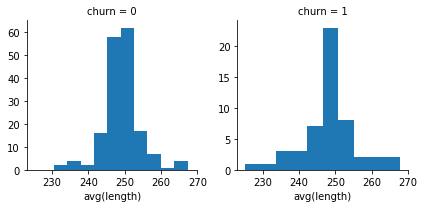

In [17]:
# get the average length for every user, keeping the churn information and transform to a Pandas dataframe
length_df = joined_df.groupBy(['userId', 'churn']).avg('length').toPandas()

# visualize the distribution of length between two groups of users
g = sns.FacetGrid(length_df, col="churn", sharey=False)
g.map(plt.hist, "avg(length)");

In [18]:
# The itemInSession variable, which represents the rank fo the song in the current sessionk
joined_df.groupBy('churn').avg('itemInSession').show(5)

+-----+------------------+
|churn|avg(itemInSession)|
+-----+------------------+
|    1|109.23299304564907|
|    0|115.94533542999396|
+-----+------------------+



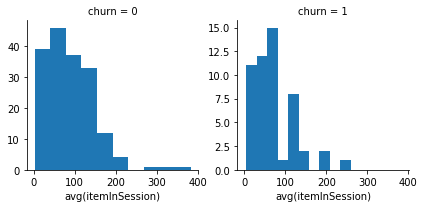

In [19]:
# Similar to length, we visualize the distribution between both groups
item_df = joined_df.groupBy(['userId','churn']).avg('itemInSession').toPandas()
g = sns.FacetGrid(item_df, col="churn", sharey=False)
g.map(plt.hist, "avg(itemInSession)");

In [20]:
# Let's create a variable representing the state
joined_df = joined_df.withColumn('state', substring(col("location"), -2, 3))

# See the most present states for people who churned 
joined_df.groupBy(['churn', 'state']).count().where(joined_df['churn'] == 0).sort(col('count').desc()).show(5)
joined_df.groupBy(['churn', 'state']).count().where(joined_df['churn'] == 1).sort(col('count').desc()).show(5)

+-----+-----+-----+
|churn|state|count|
+-----+-----+-----+
|    0|   CA|39158|
|    0|   PA|23708|
|    0|   TX|22200|
|    0|   NH|18637|
|    0|   FL|11427|
+-----+-----+-----+
only showing top 5 rows

+-----+-----+-----+
|churn|state|count|
+-----+-----+-----+
|    1|   CA| 7613|
|    1|   CO| 4317|
|    1|   MS| 3839|
|    1|   WA| 3526|
|    1|   OH| 3173|
+-----+-----+-----+
only showing top 5 rows



In [21]:
# Study potential differences based on ts
joined_df.groupBy('churn').avg('ts').show(5)

+-----+--------------------+
|churn|             avg(ts)|
+-----+--------------------+
|    1|1.539919263874465E12|
|    0|1.541159010797734...|
+-----+--------------------+



In [22]:
# the ts column is actually a unix timestamp, which we convert to a date format
joined_df = joined_df.withColumn('date', from_unixtime((col('ts')/1000)).cast(DateType()))

In [23]:
# once this is done, we can create several time based features
# first, extract day and month from the date column
joined_df = joined_df.withColumn('day', dayofmonth('date')).withColumn('month', month('date'))

# then for a given user get the average number of distinct sessions per day and per month
day_df = joined_df.groupBy(['userId', 'day']).agg(countDistinct('sessionId')).groupBy('userId').avg('count(DISTINCT sessionId)') \
                  .withColumnRenamed('avg(count(DISTINCT sessionId))', 'daily_sessions')
month_df = joined_df.groupBy(['userId', 'month']).agg(countDistinct('sessionId')).groupBy('userId').avg('count(DISTINCT sessionId)') \
                  .withColumnRenamed('avg(count(DISTINCT sessionId))', 'monthly_sessions')

# join this information back to the original joined_df for each row for a given userId, it will be used later
joined_df = joined_df.join(day_df, on='userId').join(month_df, on='userId')

In [24]:
# Compare number of daily and monthly sessions for the two groups of users
joined_df.groupBy('churn').avg('daily_sessions').show()
joined_df.groupBy('churn').avg('monthly_sessions').show()

+-----+-------------------+
|churn|avg(daily_sessions)|
+-----+-------------------+
|    1| 1.3486546923719596|
|    0| 1.6796452897398528|
+-----+-------------------+

+-----+---------------------+
|churn|avg(monthly_sessions)|
+-----+---------------------+
|    1|    9.296020565858312|
|    0|   14.264002136651344|
+-----+---------------------+



In [25]:
# Study potential differences based on registration
joined_df.groupBy(['churn', 'registration']).count().where(joined_df['churn'] == 0).sort(col('count').desc()).show(5)
joined_df.groupBy(['churn', 'registration']).count().where(joined_df['churn'] == 1).sort(col('count').desc()).show(5)

+-----+-------------+-----+
|churn| registration|count|
+-----+-------------+-----+
|    0|1529027541000| 9632|
|    0|1536403972000| 7230|
|    0|1536642109000| 6880|
|    0|1538336771000| 5732|
|    0|1532224335000| 4825|
+-----+-------------+-----+
only showing top 5 rows

+-----+-------------+-----+
|churn| registration|count|
+-----+-------------+-----+
|    1|1536988041000| 3603|
|    1|1532482662000| 3437|
|    1|1538080987000| 2464|
|    1|1526739206000| 2168|
|    1|1535066380000| 2149|
+-----+-------------+-----+
only showing top 5 rows



In [26]:
# Study potential differences based on user agent
joined_df.groupBy(['churn', 'userAgent']).count().where(joined_df['churn'] == 0).sort(col('count').desc()).show(5)
joined_df.groupBy(['churn', 'userAgent']).count().where(joined_df['churn'] == 1).sort(col('count').desc()).show(5)

+-----+--------------------+-----+
|churn|           userAgent|count|
+-----+--------------------+-----+
|    0|"Mozilla/5.0 (Win...|18226|
|    0|"Mozilla/5.0 (Mac...|16298|
|    0|"Mozilla/5.0 (Mac...|15914|
|    0|"Mozilla/5.0 (Win...|15237|
|    0|Mozilla/5.0 (Wind...|15224|
+-----+--------------------+-----+
only showing top 5 rows

+-----+--------------------+-----+
|churn|           userAgent|count|
+-----+--------------------+-----+
|    1|"Mozilla/5.0 (Mac...| 4736|
|    1|"Mozilla/5.0 (Win...| 4525|
|    1|Mozilla/5.0 (Wind...| 3437|
|    1|"Mozilla/5.0 (Mac...| 2534|
|    1|Mozilla/5.0 (Maci...| 2462|
+-----+--------------------+-----+
only showing top 5 rows



In [27]:
# For a given user we compute number of downgrades, upgrades, thumbs up, thumbs down, add friend, add to playlist, roll advert

# Create a column for each of these events, with a 1 each time they occur
for c in ['Downgrade', 'Roll Advert', 'Thumbs Down', 'Add to Playlist', 'Add Friend', 'Thumbs Up']:
    joined_df = joined_df.withColumn(c, (joined_df['Page'] == c).cast(IntegerType()))
    
# Prepare data for the pipeline
features_df = joined_df.groupBy('userId').agg(avg('itemInSession'), 
                                              avg('length'),
                                              min('daily_sessions'),
                                              min('monthly_sessions'),
                                            max('level'), 
                                            max('userAgent'),
                                           max('state'),
                                           sum('Downgrade'),
                                           sum('Roll Advert'),
                                           sum('Thumbs Down'),
                                           sum('Add to Playlist'),
                                           sum('Add Friend'),
                                           sum('Thumbs Up'),
                                           max('churn'))

features_df = features_df.select(col('avg(itemInSession)').alias('itemInSession'),
                                 col('avg(length)').alias('length'),
                                 col('min(daily_sessions)').alias('daily_sessions'),
                                 col('min(monthly_sessions)').alias('monthly_sessions'),
                  col('max(level)').alias('level'),
                  col('max(userAgent)').alias('userAgent'),
                  col('max(state)').alias('state'),
                  col('sum(Downgrade)').alias('downgrade'),
                  col('sum(Roll Advert)').alias('rollAdvert'),
                  col('sum(Thumbs Down)').alias('thumbsDown'),
                  col('sum(Add to Playlist)').alias('addToPlaylist'),
                  col('sum(Add Friend)').alias('addFriend'),
                  col('sum(Thumbs Up)').alias('thumbsUp'),
                  col('max(churn)').alias('label'))

In [28]:
# Visualize the presence of potential null values
features_df.select([count(when(isnull(c), c)).alias(c) for c in features_df.columns]).show()

# Remove these null values
features_df = features_df.where(col("userAgent").isNotNull()).where(col("state").isNotNull())

+-------------+------+--------------+----------------+-----+---------+-----+---------+----------+----------+-------------+---------+--------+-----+
|itemInSession|length|daily_sessions|monthly_sessions|level|userAgent|state|downgrade|rollAdvert|thumbsDown|addToPlaylist|addFriend|thumbsUp|label|
+-------------+------+--------------+----------------+-----+---------+-----+---------+----------+----------+-------------+---------+--------+-----+
|            0|     1|             0|               0|    0|        1|    1|        0|         0|         0|            0|        0|       0|    0|
+-------------+------+--------------+----------------+-----+---------+-----+---------+----------+----------+-------------+---------+--------+-----+



After studying distribution of various features between users who churned and those who did not, we choose these specific features for our model:
- although on average the length is the same, digging into the distribution between these two groups shows some slight differences so we include this feature in our model
- after a similar reasoning, we include item in session (which loosely translates to the number of songs per session) in our model
- the tier (18.6% free for people who churned vs. 27.6% free for people who churned) and the state appear to provide information as to whether a user will churn or not 
- realizing that the ts column is actually a unix timestamp, we can convert it to a date and extract time-based features such as the average number of sessions per day and per month. Both these features vary between both groups so we include them in our model
- we also assume on-platform behaviors (thumbs up e.g.) will be informative so we include them in the model.

In our aggregation per user, we have to limit ourselves to one level/state and user agent, chosen at random, which could be a potential issue if they changed, but the distributed nature of Spark makes mode implementation tricky and hence we rely on a random choice.

We also have to remove a few missing values.

# Modeling


In [29]:
# We first create a pipeline to prepare our data for modeling
indexer_state = StringIndexer(inputCol='state', outputCol='state_index')
indexer_level = StringIndexer(inputCol='level', outputCol='level_index')
indexer_ua = StringIndexer(inputCol='userAgent', outputCol='userAgent_index')
assembler = VectorAssembler(inputCols=['itemInSession', 
                                       'length',
                                       'daily_sessions',
                                       'monthly_sessions',
                                       'level_index', 
                                       'state_index',
                                       'userAgent_index',
                                       'downgrade',
                                       'rollAdvert',
                                       'thumbsDown',
                                       'addToPlaylist',
                                       'addFriend',
                                       'thumbsUp'],
                           outputCol='features')
features_pipeline = Pipeline(stages=[indexer_state, indexer_level, indexer_ua, assembler])

model_df = features_pipeline.fit(features_df).transform(features_df)

In [30]:
# Due to the structure of data, we need to convert some features vector from Sparse to Dense
df2 = model_df.select("label", "features")
rdd = df2.rdd.map(lambda x: Row(label=x[0],features=DenseVector(x[1].toArray()))
                     if (len(x)>1 and hasattr(x[1], "toArray"))
                     else Row(label=None, features=DenseVector([])))
model_data = spark.createDataFrame(rdd)

In [44]:
# Create a function to train and estimate a model
def fit_estimate(train, test, model):
    '''
    INPUTS:
    train (Spark df): a Spark data frame with training data
    test (Spark df): a Spark data frame with testing data
    model (string): a string designating one of the models to fit, either 'logistic_regression', 'random_forest' 
                    or 'gradient_boosting'
    
    OUTPUT:
    None, prints out accuracy for the model
    
    DESCRIPTION:
    Fits and estimates different classification models with the default parameters
    '''
    # Choose the model
    if model == 'logistic_regression':
        ml = LogisticRegression()
    elif model == 'random_forest':
        ml = RandomForestClassifier()
    elif model == 'gradient_boosting':
        ml = GBTClassifier()
    else:
        return "Please choose an appropriate model"
    
    # Fit and calculate predictions
    classification = ml.fit(train)
    results = classification.transform(test)
    
    # Calculate accuracy and F-1 score
    accuracy_evaluator = MulticlassClassificationEvaluator(metricName='accuracy')
    accuracy = accuracy_evaluator.evaluate(results.select(col('label'), col('prediction')))
    
    f1_score_evaluator = MulticlassClassificationEvaluator(metricName='f1')
    f1_score = f1_score_evaluator.evaluate(results.select(col('label'), col('prediction')))
    
    print('For {}, the accuracy on the test set is {:.2%} and the F-1 score is {}'\
    .format(model, accuracy, f1_score))

In [ ]:
# Split this data between train, validation and test sets
train, test = model_data.randomSplit([0.8, 0.2], seed=42)

# Due to the class imbalance, we upsample the categories who churned in the training dataset
print('In our training set, we have {} users who churned and {} who did not.'.format(train.where(col('label') == 1).count(),
                                                                                           train.where(col('label') == 0).count()))

train_churn = train.where(col('label') == 1).sample(True, train.where(col('label') == 0).count()/train.where(col('label') == 1).count())
train_no_churn = train.where(col('label') == 0)
train = train_churn.unionAll(train_no_churn)

In our training set, we have 41 users who churned and 150 who did not.


In [ ]:
# Fit various models and visualize their accuracies
for model in ['logistic_regression', 'random_forest', 'gradient_boosting']:
    fit_estimate(train, test, model)

For logistic_regression, the accuracy on the test set is 76.47% and the F-1 score is 0.7578431372549018


These three models perform quite similarly. We choose to optimize the logistic regression model: its F-score is the highest but it has not the worst accuracy. Nonetheless, its coefficients make it easy to interpret the impact of specific features. We choose to optimize to the accuracy and not F1 score since we took care of the class imbalance before.

In [34]:
# Optimize a model, gradient boosting since higher F-1 Score
model = LogisticRegression()
param_grid = ParamGridBuilder() \
    .addGrid(model.regParam, [0.0, 0.1, 0.3]) \
    .build()

crossval = CrossValidator(estimator = Pipeline(stages=[model]),
                         estimatorParamMaps = param_grid,
                         evaluator = MulticlassClassificationEvaluator(metricName='accuracy'),
                         numFolds = 3)

classification = crossval.fit(train)
results = classification.transform(test)

# Calculate accuracy and F-1 score
accuracy_evaluator = MulticlassClassificationEvaluator(metricName='accuracy')
accuracy = accuracy_evaluator.evaluate(results.select(col('label'), col('prediction')))

f1_score_evaluator = MulticlassClassificationEvaluator(metricName='f1')
f1_score = f1_score_evaluator.evaluate(results.select(col('label'), col('prediction')))

print('For {}, the accuracy on the test set is {:.2%} and the F-1 score is {}'\
.format(model, accuracy, f1_score))

For the optimized model, the accuracy on the test set is 67.65% and the F-1 score is 0


We first had to convert all our features to numeric, with the help of a processing pipeline. Then, we upsampled the "churn" category in our training dataset in order to fight the class imbalance which is present. We choose this rather than downsampling due to the small number of people present in our dataset (362 in the training set). Nonetheless, it is important to leave the test set as is in order for it to be a true representation of what would happen in the real world.

We fitted several models with the default parameters to get a sense of which performs best "out of the box". After this, we used cross-validation to tune the hyperparameters of the model, and reached % accuracy and a F-1 score of ?? with ??. 

While having a model is very powerful to flag people "at risk" for the company and hence target them with interesting offers (discounts, more attention), it is also insightful to visualize which elements are most important in predicting churn. Looking at feature importance ??

# Conclusion

Include reflection and potential improvement (end-to-end problem solving, one or two aspects I found particularly challenging or interesting).